In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = { 'pandas','numpy', 'matplotlib', 'seaborn','toad','pickle','sklearn'}
missing = required - installedPackages
if missing:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install toad
    !pip install pickle
    !pip install sklearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle


# 1. Data Preprocessing

In [3]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data


def target_info(df_target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    proportion_true=str(round(sum(df_target_column == True) / len(df_target_column), 2) * 100)
    
    proportion_false=str(round(sum(df_target_column == False) / len(df_target_column), 3) * 100)
    
    print('There are total {} records in our data.'.format(len(df_target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(df_target_column == True)))
    print('Proportion (Fraud): {}'.format(proportion_true
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(df_target_column == False)))
    print('Proportion (Not Fraud): {}'.format(proportion_false
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=df_target_column.value_counts().index, y=df_target_column.value_counts())
    plt.title('Not Fraud vs Fraud Counts')
    plt.ylabel('Count')
    return proportion_true



In [4]:
# use pandas to load the csv file
data = pd.read_csv('UCI_Credit_Card.csv')

In [5]:
# check the size of the data
data.shape

(30000, 25)

In [6]:
# check few lines
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
#use the world 'label'
data['label']=data['default.payment.next.month']
data=data.drop(columns=['default.payment.next.month'])

In [8]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


There are total 30000 records in our data.
Is Fraud:
Count: 6636
Proportion (Fraud): 22.0%
Not Fraud:
Count: 23364
Proportion (Not Fraud): 77.9%


'22.0'

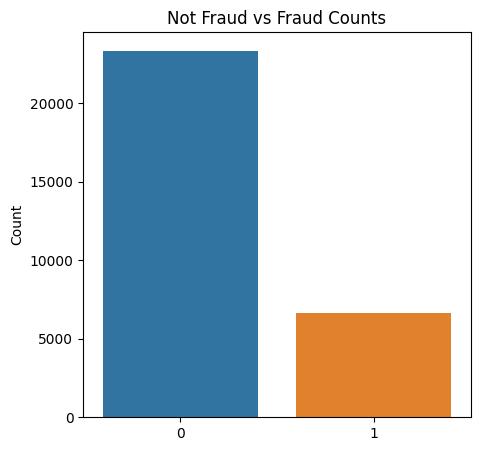

In [9]:
#check the fraud proportion of the data
target_info(data['label'])

In [10]:
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']

In [11]:
data.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [12]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [13]:
train.label.value_counts()

0    17411
1     5088
Name: label, dtype: int64

In [14]:
test.label.value_counts()

0    5953
1    1548
Name: label, dtype: int64

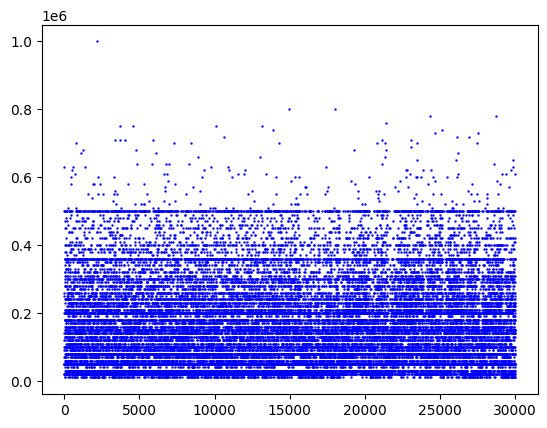

In [15]:
plt.scatter(x=data['ID'] ,y=data['LIMIT_BAL'], s=0.5,edgecolors='blue')

In [16]:
import math
import numpy as np
data['AGE_RANGE'] = (data['AGE']/10).apply(np.floor)*10


# sns.barplot(x = plot_data['AGE'], y = plot_data['LIMIT_BAL'])
data

plot_data = data[['AGE_RANGE', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'label']].copy()

plot_data

,AGE_RANGE,LIMIT_BAL,SEX,EDUCATION,label
0,20.0,20000.0,2,2,1
1,20.0,120000.0,2,2,1
2,30.0,90000.0,2,2,0
3,30.0,50000.0,2,2,0
4,50.0,50000.0,1,2,0
...,...,...,...,...,...
29995,30.0,220000.0,1,3,0
29996,40.0,150000.0,1,3,0
29997,30.0,30000.0,1,2,1
29998,40.0,80000.0,1,3,1


In [17]:
count = 0
sum = 0
for i in range(30000):
    if(plot_data['AGE_RANGE'][i] == 70.0):
        sum = sum + plot_data['LIMIT_BAL'][i]
        count = count + 1
print(sum/count)

218800.0


<AxesSubplot: xlabel='AGE_RANGE'>

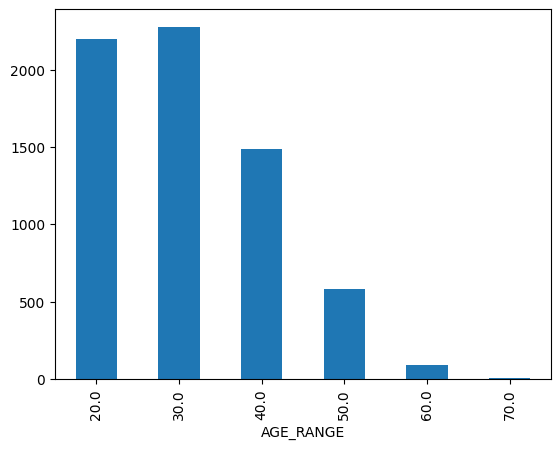

In [18]:
plot_data.groupby(["AGE_RANGE"]).sum()['label'].plot.bar()

<AxesSubplot: xlabel='SEX'>

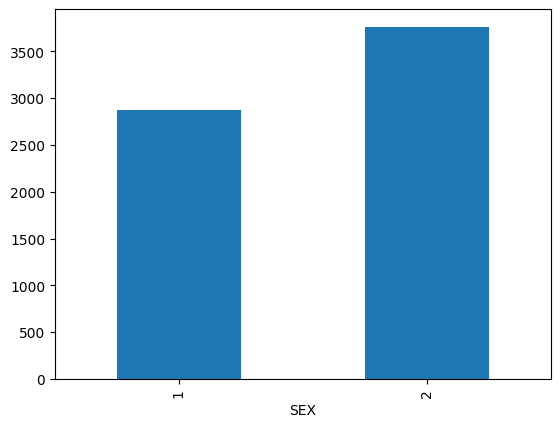

In [19]:
plot_data.groupby(["SEX"]).sum()['label'].plot.bar()

<AxesSubplot: xlabel='EDUCATION'>

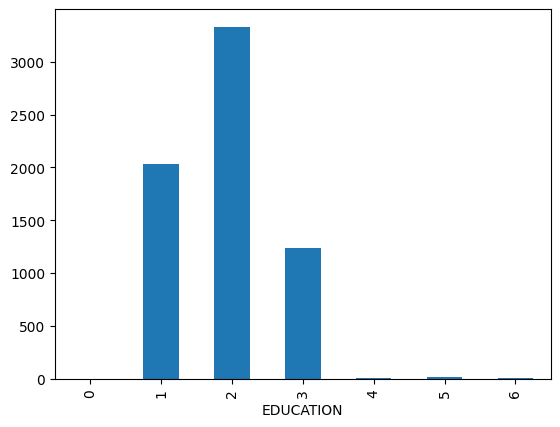

In [20]:
plot_data.groupby(["EDUCATION"]).sum()['label'].plot.bar()

/tmp/ipykernel_92528/1078716300.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
/tmp/ipykernel_92528/1078716300.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, bins = bins, kde = use_kde)
/tmp/ipykernel_92528/1078716300.py:10: UserWarning: 



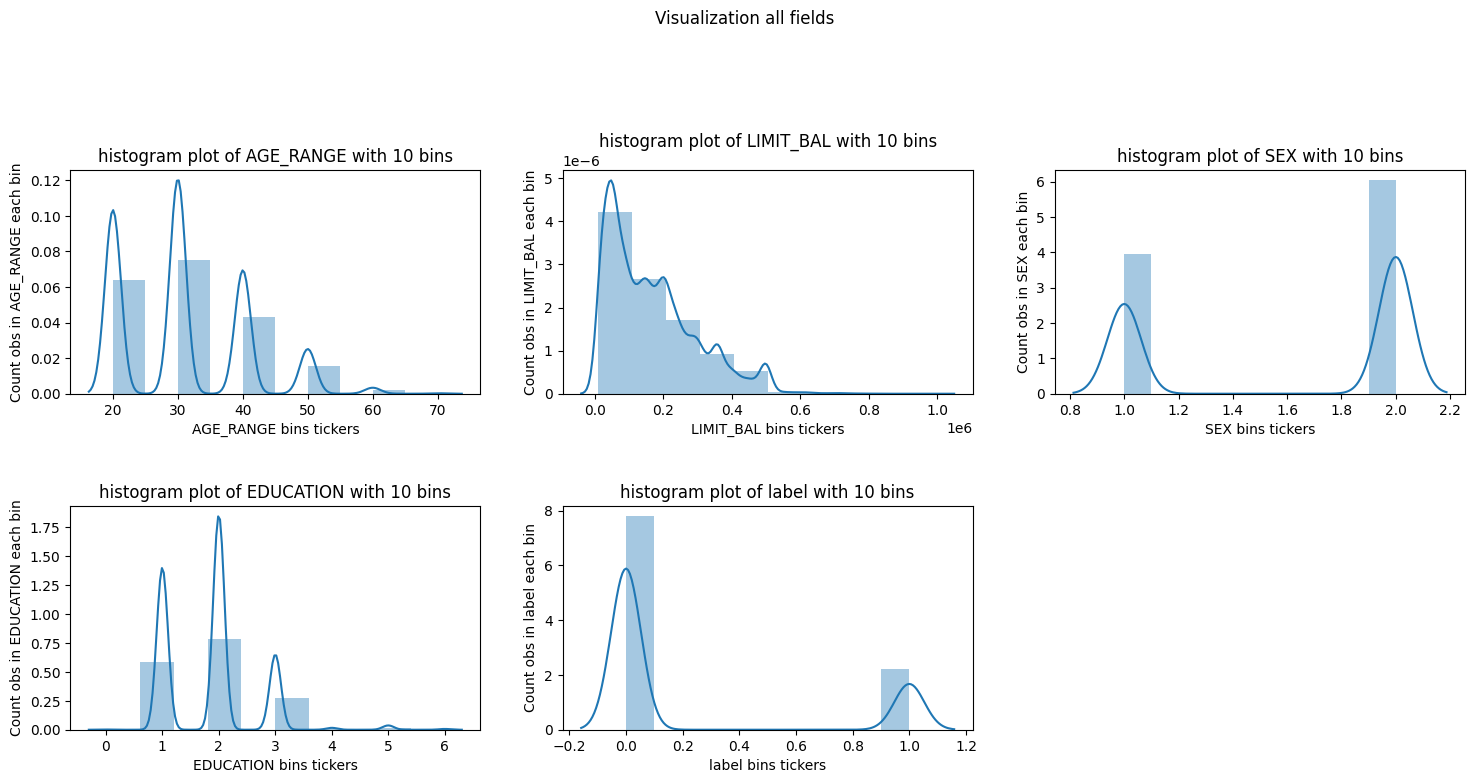

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram
def _plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
    x = x.dropna()
    xlabel = '{} bins tickers'.format(fieldname)
    ylabel = 'Count obs in {} each bin'.format(fieldname)
    title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
    ax = sns.distplot(x, bins = bins, kde = use_kde)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return ax

# Barchart
def _plot_barchart_subplot(x, fieldname):
    xlabel = 'Group of {}'.format(fieldname)
    ylabel = 'Count obs in {} each bin'.format(fieldname)
    title = 'Barchart plot of {}'.format(fieldname)
    x = x.fillna('Missing')
    df_summary = x.value_counts(dropna = False)
    y_values = df_summary.values
    x_index = df_summary.index
    ax = sns.barplot(x = x_index, y = y_values, order = x_index)
    
    # Get list of chart label
    labels = list(set(x))
    for label, p in zip(y_values, ax.patches):
        ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    return ax

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
for i, (fieldname, dtype) in enumerate(zip(plot_data.columns, plot_data.dtypes.values)):
    if i <= 11:
        ax_i = fig.add_subplot(4, 3, i+1)
    if dtype in ['float64', 'int64']:
        ax_i = _plot_hist_subplot(plot_data[fieldname], fieldname=fieldname)
    else:
        ax_i = _plot_barchart_subplot(plot_data[fieldname], fieldname=fieldname)

fig.suptitle('Visualization all fields')
plt.show()

# 2. Feature Filtering

In [22]:
data=data.drop(columns=['AGE_RANGE'])

In [23]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features

train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))


keep: 23 drop empty: 0 drop iv: 2 drop corr: 0


In [24]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [25]:
train_selected

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000.0,2,24,2,2,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,26,-1,2,0,0,0,2,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,34,0,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,37,0,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,2,57,-1,0,-1,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,22495,70000.0,3,49,2,2,2,0,0,0,...,17153.0,17866.0,19413.0,4500.0,0.0,2000.0,1000.0,2000.0,691.0,1
22495,22496,50000.0,3,46,-2,-1,0,0,0,0,...,19792.0,19422.0,19830.0,7084.0,1000.0,19286.0,664.0,689.0,761.0,0
22496,22497,50000.0,3,32,0,0,0,0,0,0,...,15996.0,32714.0,16720.0,1868.0,2300.0,1239.0,600.0,600.0,600.0,1
22497,22498,440000.0,2,46,0,0,0,0,0,0,...,149944.0,113135.0,105280.0,7700.0,8610.0,6907.0,3727.0,3800.0,4001.0,0


In [26]:
toad.detect(train)#[:10]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
ID,int64,22499,0.00%,22499,11250.000000,6495.046189,1.0,225.98,2250.8,11250.0,16874.5,20249.2,22274.02,22499.0
LIMIT_BAL,float64,22499,0.00%,77,163413.204142,128506.717166,10000.0,10000.00,30000.0,130000.0,230000.0,360000.0,500000.00,1000000.0
SEX,int64,22499,0.00%,2,1.610160,0.487725,1.0,1.00,1.0,2.0,2.0,2.0,2.00,2.0
EDUCATION,int64,22499,0.00%,7,1.840660,0.775198,0.0,1.00,1.0,2.0,2.0,3.0,4.00,6.0
MARRIAGE,int64,22499,0.00%,4,1.564158,0.521309,0.0,1.00,1.0,2.0,2.0,2.0,3.00,3.0
AGE,int64,22499,0.00%,55,35.212809,9.307465,21.0,22.00,25.0,33.0,41.0,49.0,60.00,79.0
PAY_0,int64,22499,0.00%,11,0.015067,1.119849,-2.0,-2.00,-1.0,0.0,0.0,2.0,3.00,8.0
PAY_2,int64,22499,0.00%,11,-0.106983,1.197151,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0
PAY_3,int64,22499,0.00%,11,-0.137428,1.202663,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0
PAY_4,int64,22499,0.00%,11,-0.197298,1.164358,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0


In [27]:
toad.quality(data,'label',iv_only=True)[:25]

,iv,gini,entropy,unique
PAY_0,0.877149,NaN,NaN,11.0
PAY_2,0.548952,NaN,NaN,11.0
PAY_3,0.416045,NaN,NaN,11.0
PAY_4,0.367265,NaN,NaN,11.0
PAY_5,0.340329,NaN,NaN,10.0
PAY_6,0.293814,NaN,NaN,10.0
PAY_AMT1,0.193553,NaN,NaN,7943.0
LIMIT_BAL,0.183522,NaN,NaN,81.0
PAY_AMT2,0.173619,NaN,NaN,7899.0
PAY_AMT3,0.139372,NaN,NaN,7518.0


In [28]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [29]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'MARRIAGE'], dtype=object),
 'corr': array([], dtype=object)}

In [30]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv = feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [31]:
df_iv.shape

(22, 2)

In [32]:
df_iv.head(30)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_3,0.401513
3,PAY_4,0.349813
4,PAY_5,0.340014
5,PAY_6,0.282692
6,PAY_AMT1,0.189334
7,LIMIT_BAL,0.170973
8,PAY_AMT2,0.168256
9,PAY_AMT3,0.128827


# 3. Feature Binning

In [33]:
train_selected.label.value_counts()

0    17411
1     5088
Name: label, dtype: int64

In [34]:
train_selected.shape

(22499, 23)

In [35]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

0.4351541558901469


In [36]:
combiner

In [37]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [38]:
filename

'CreditScore_save1_combiner.pkl'

In [39]:
# load the model from disk
#combiner = pickle.load(open(filename, 'rb'))

In [40]:
#output binning
bins = combiner.export()

In [41]:
len(bins)

21

In [42]:
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'EDUCATION': [2],
 'AGE': [26, 29, 34, 46],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_3': [-1, 0, 2],
 'PAY_4': [-1, 0, 1],
 'PAY_5': [-1, 0, 2],
 'PAY_6': [-1, 0, 2],
 'BILL_AMT1': [2501.0],
 'BILL_AMT2': [2400.0, 8287.0, 35213.0],
 'BILL_AMT3': [2400.0, 7458.0, 81890.0],
 'BILL_AMT4': [2501.0],
 'BILL_AMT5': [2395.0, 8110.0, 35288.0],
 'BILL_AMT6': [19195.0, 50442.0],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [43]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test[train_selected_bin.columns])

In [44]:
test_bin

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,7,1,3,2,1,2,1,2,2,...,1,3,2,2,2,2,3,2,6,0
1,22501,5,1,2,1,1,1,1,1,1,...,1,0,0,0,1,2,2,2,5,0
2,22502,6,0,2,2,1,2,2,2,2,...,1,3,1,1,2,1,2,2,5,0
3,22503,1,1,3,2,1,3,3,3,2,...,1,2,1,1,2,0,0,1,2,1
4,22504,6,1,2,2,1,2,2,2,2,...,1,3,2,2,3,2,3,2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,29996,5,1,3,2,1,2,2,2,2,...,1,2,0,2,4,2,2,2,3,0
7497,29997,5,1,3,1,1,1,1,2,2,...,1,1,0,1,2,2,1,0,0,0
7498,29998,0,1,3,4,2,3,1,2,2,...,1,2,1,0,0,2,3,2,5,1
7499,29999,3,1,3,3,1,2,2,2,1,...,1,2,1,2,2,1,2,3,5,1


In [45]:
train_selected_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0,1,0,4,2,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,4,1,1,1,2,2,2,2,3,...,1,1,0,0,1,1,1,0,5,1
2,3,3,1,3,2,1,2,2,2,2,...,1,2,0,1,1,1,1,1,6,0
3,4,1,1,3,2,1,2,2,2,2,...,1,2,1,1,2,1,1,1,3,0
4,5,1,1,4,1,1,1,2,2,2,...,1,2,0,1,4,2,3,1,2,0


In [46]:
train_selected

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,20000.0,2,24,2,2,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,26,-1,2,0,0,0,2,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,34,0,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,37,0,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,2,57,-1,0,-1,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,22495,70000.0,3,49,2,2,2,0,0,0,...,17153.0,17866.0,19413.0,4500.0,0.0,2000.0,1000.0,2000.0,691.0,1
22495,22496,50000.0,3,46,-2,-1,0,0,0,0,...,19792.0,19422.0,19830.0,7084.0,1000.0,19286.0,664.0,689.0,761.0,0
22496,22497,50000.0,3,32,0,0,0,0,0,0,...,15996.0,32714.0,16720.0,1868.0,2300.0,1239.0,600.0,600.0,600.0,1
22497,22498,440000.0,2,46,0,0,0,0,0,0,...,149944.0,113135.0,105280.0,7700.0,8610.0,6907.0,3727.0,3800.0,4001.0,0


In [47]:
test_bin.head()

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,7,1,3,2,1,2,1,2,2,...,1,3,2,2,2,2,3,2,6,0
1,22501,5,1,2,1,1,1,1,1,1,...,1,0,0,0,1,2,2,2,5,0
2,22502,6,0,2,2,1,2,2,2,2,...,1,3,1,1,2,1,2,2,5,0
3,22503,1,1,3,2,1,3,3,3,2,...,1,2,1,1,2,0,0,1,2,1
4,22504,6,1,2,2,1,2,2,2,2,...,1,3,2,2,3,2,3,2,6,1


In [48]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
features_list

['LIMIT_BAL',
 'EDUCATION',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

<AxesSubplot: xlabel='PAY_AMT1', ylabel='prop'>

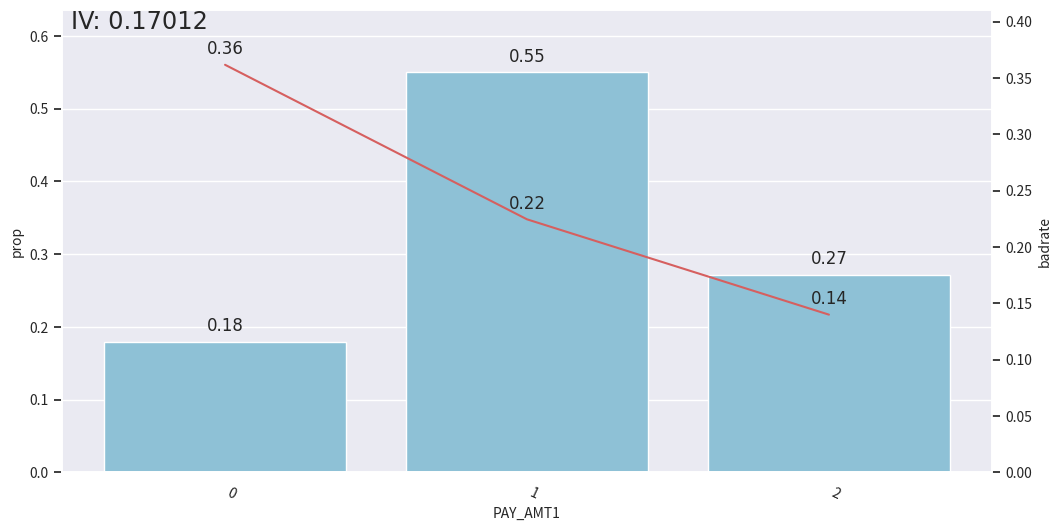

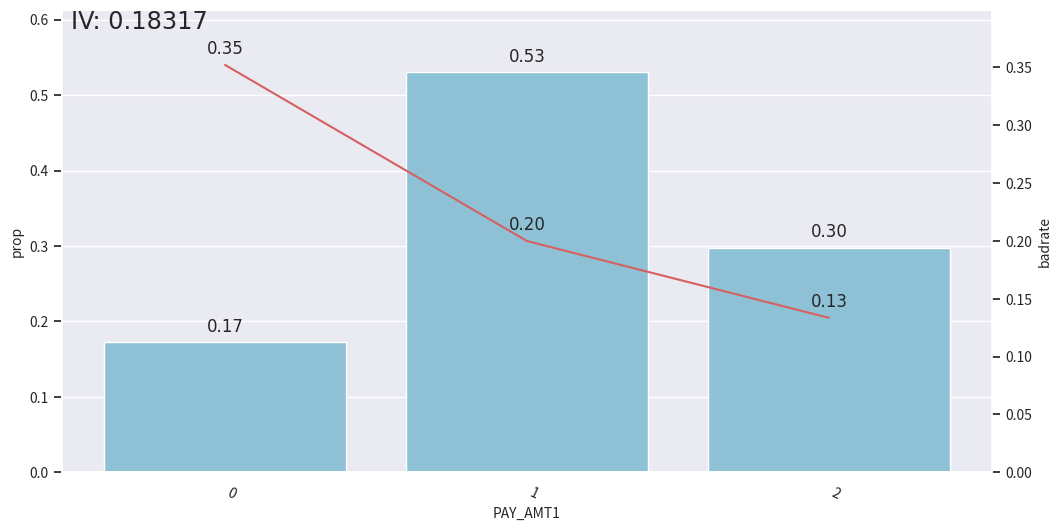

In [49]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

In [50]:
#setting rules
#rule = {'PAY_AMT1':[['0', 'nan'],['1'], ['2'], ['3']]}

#Adjust binning
#c.set_rules(rule)

In [51]:
train_selected_bin.PAY_0.describe()

count    22499.000000
mean         1.988711
std          1.038531
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: PAY_0, dtype: float64

# 4. Transform to WOE

In [52]:
##转化成WOE映射
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

In [53]:
train_woe

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22494,22495,0.346262,0.089338,0.156679,2.019269,1.459809,1.305413,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,0.544728,0.016060,0.056501,-0.188927,0.257636,1
22495,22496,0.200392,0.089338,0.156679,-0.675097,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.585644,0.124160,-0.372758,0.056501,0.084926,0.257636,0
22496,22497,0.200392,0.089338,-0.197887,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-0.076846,0.016060,0.056501,0.084926,0.257636,1
22497,22498,-0.693420,0.089338,0.156679,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,-0.068485,-0.088061,-0.585644,-0.407943,-0.372758,-0.106759,-0.188927,-0.082401,0


In [54]:
test_woe

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,-0.693420,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.383479,-0.203587,-0.201216,...,-0.009858,-0.068485,-0.088061,-0.585644,-0.076846,-0.372758,-0.457199,-0.188927,-0.391360,0
1,22501,-0.280994,0.089338,-0.197887,-0.308169,-0.408118,-0.417749,-0.383479,-0.396177,-0.335730,...,-0.009858,-0.006521,-0.034304,0.662394,0.124160,-0.372758,-0.106759,-0.188927,-0.082401,0
2,22502,-0.436625,-0.174478,-0.197887,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,-0.068485,0.162615,-0.009085,-0.076846,0.016060,-0.106759,-0.188927,-0.082401,0
3,22503,0.200392,0.089338,-0.028816,-0.677822,-0.408118,1.305413,1.370613,1.443205,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.488183,0.454327,0.084926,0.257636,1
4,22504,-0.436625,0.089338,-0.197887,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,-0.068485,-0.088061,-0.585644,-0.407943,-0.372758,-0.457199,-0.188927,-0.391360,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,29996,-0.280994,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.585644,-1.078550,-0.372758,-0.106759,-0.188927,-0.119586,0
7497,29997,-0.280994,0.089338,-0.028816,-0.308169,-0.408118,-0.417749,-0.383479,-0.203587,-0.201216,...,-0.009858,-0.239312,-0.034304,-0.009085,-0.076846,-0.372758,0.056501,0.370272,0.343887,0
7498,29998,0.666522,0.089338,-0.028816,2.019269,1.459809,1.305413,-0.383479,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,0.662394,0.544728,-0.372758,-0.457199,-0.188927,-0.082401,1
7499,29999,0.108342,0.089338,-0.028816,0.583884,-0.408118,-0.296556,-0.230510,-0.203587,-0.335730,...,-0.009858,0.140562,0.162615,-0.585644,-0.076846,0.016060,-0.106759,-0.704351,-0.082401,1


In [55]:
final_data_woe = pd.concat([train_woe,test_woe])


In [56]:
final_data_woe

,ID,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,0.089338,0.260065,2.019269,1.459809,-0.417749,-0.383479,-0.146325,-0.117947,...,0.028510,-0.006521,-0.034304,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,0.089338,-0.100163,-0.308169,1.459809,-0.296556,-0.230510,-0.203587,1.282840,...,-0.009858,-0.239312,-0.034304,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,0.089338,0.156679,-0.308169,-0.408118,-0.417749,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,29996,-0.280994,0.089338,-0.028816,-0.677822,-0.408118,-0.296556,-0.230510,-0.203587,-0.201216,...,-0.009858,0.140562,-0.034304,-0.585644,-1.078550,-0.372758,-0.106759,-0.188927,-0.119586,0
7497,29997,-0.280994,0.089338,-0.028816,-0.308169,-0.408118,-0.417749,-0.383479,-0.203587,-0.201216,...,-0.009858,-0.239312,-0.034304,-0.009085,-0.076846,-0.372758,0.056501,0.370272,0.343887,0
7498,29998,0.666522,0.089338,-0.028816,2.019269,1.459809,1.305413,-0.383479,-0.203587,-0.201216,...,-0.009858,0.140562,0.162615,0.662394,0.544728,-0.372758,-0.457199,-0.188927,-0.082401,1
7499,29999,0.108342,0.089338,-0.028816,0.583884,-0.408118,-0.296556,-0.230510,-0.203587,-0.335730,...,-0.009858,0.140562,0.162615,-0.585644,-0.076846,0.016060,-0.106759,-0.704351,-0.082401,1


In [57]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [58]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]

In [59]:
features_use

['LIMIT_BAL',
 'EDUCATION',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

## Calculate PSI
* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.2

In [60]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

/tmp/ipykernel_92528/1100552231.py:4: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)


In [61]:
psi_df

,feature,psi
0,EDUCATION,0.000258
1,BILL_AMT4,0.000330
2,BILL_AMT6,0.001591
3,BILL_AMT5,0.002520
4,BILL_AMT1,0.002634
5,PAY_AMT5,0.003066
6,PAY_AMT1,0.003402
7,PAY_AMT4,0.004556
8,BILL_AMT2,0.005398
9,PAY_AMT6,0.007230


In [62]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

In [63]:
psi_remove

[]

In [64]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
        psi025.append(i) 

In [65]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [66]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [67]:
print(final_data_woe.shape)

(30000, 23)


In [68]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

In [69]:
final_data_woe

,EDUCATION,BILL_AMT4,BILL_AMT6,BILL_AMT5,BILL_AMT1,PAY_AMT5,PAY_AMT1,PAY_AMT4,BILL_AMT2,PAY_AMT6,...,PAY_3,PAY_2,PAY_5,PAY_AMT3,LIMIT_BAL,PAY_6,PAY_0,AGE,ID,label
0,0.089338,0.028510,-0.034304,-0.006521,-0.024371,0.370272,0.662394,0.454327,-0.061447,0.343887,...,-0.417749,1.459809,-0.146325,0.488183,0.666522,-0.117947,2.019269,0.260065,1,1
1,0.089338,-0.009858,-0.034304,-0.239312,-0.024371,0.370272,0.662394,0.056501,-0.007253,-0.082401,...,-0.296556,1.459809,-0.203587,0.016060,-0.034630,1.282840,-0.308169,-0.100163,2,1
2,0.089338,-0.009858,-0.034304,0.140562,-0.024371,0.084926,-0.009085,0.056501,0.147659,-0.391360,...,-0.296556,-0.408118,-0.203587,0.016060,0.108342,-0.201216,-0.677822,-0.028816,3,0
3,0.089338,-0.009858,0.162615,0.140562,-0.024371,0.084926,-0.009085,0.056501,-0.083006,-0.119586,...,-0.296556,-0.408118,-0.203587,0.016060,0.200392,-0.201216,-0.677822,-0.028816,4,0
4,0.089338,-0.009858,-0.034304,0.140562,-0.024371,0.084926,-0.009085,-0.457199,-0.061447,0.257636,...,-0.417749,-0.408118,-0.203587,-0.372758,0.200392,-0.201216,-0.308169,0.156679,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,0.089338,-0.009858,-0.034304,0.140562,-0.024371,-0.188927,-0.585644,-0.106759,-0.083006,-0.119586,...,-0.296556,-0.408118,-0.203587,-0.372758,-0.280994,-0.201216,-0.677822,-0.028816,29996,0
7497,0.089338,-0.009858,-0.034304,-0.239312,0.085432,0.370272,-0.009085,0.056501,-0.007253,0.343887,...,-0.417749,-0.408118,-0.203587,-0.372758,-0.280994,-0.201216,-0.308169,-0.028816,29997,0
7498,0.089338,-0.009858,0.162615,0.140562,-0.024371,-0.188927,0.662394,-0.457199,-0.061447,-0.082401,...,1.305413,1.459809,-0.203587,-0.372758,0.666522,-0.201216,2.019269,-0.028816,29998,1
7499,0.089338,-0.009858,0.162615,0.140562,0.085432,-0.704351,-0.585644,-0.106759,-0.083006,-0.082401,...,-0.296556,-0.408118,-0.203587,0.016060,0.108342,-0.335730,0.583884,-0.028816,29999,1


# 5. Output IV

In [70]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

21

In [71]:
df_iv=output_iv_importance(final_data_woe[features_use+['label']],'label')

In [72]:
df_iv

,name,iv
0,PAY_0,0.873565
1,PAY_2,0.546857
2,PAY_3,0.412420
3,PAY_4,0.359289
4,PAY_5,0.333734
5,PAY_6,0.285164
6,LIMIT_BAL,0.181621
7,PAY_AMT1,0.173425
8,PAY_AMT2,0.162703
9,PAY_AMT3,0.114630


In [73]:
#save 4: information value after woe transformation
df_iv.to_csv('CreditScore_save4_IV.csv')

# 6. Model Tuning

In [74]:
def check_train_test_auc(x_train,y_train,x_test,y_test):

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report

    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(lr, x_test, y_test, color='blue', ax=ax)

## Logistic Regression

train KS 0.40988185783295383
train AUC 0.7703247269401365
Test KS 0.4264763906414198
Test AUC 0.7834676433960946


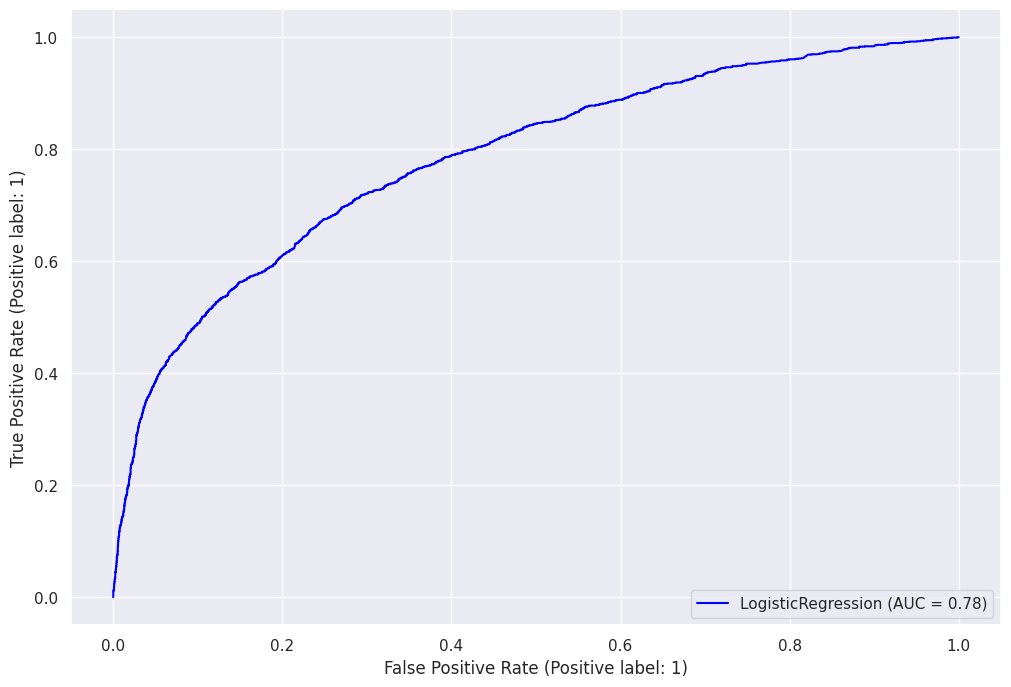

In [75]:
#train & test

check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['label'],x_test =test_woe[features_use] ,y_test = test_woe['label'])

In [76]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    tp, fn, fp, tn = confusion_matrix(label,predictions,labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print('accuracy: ',accuracy)
    recall = tp/(tp+fn)
    print('（recall）: ',recall)
    precision = tp/(tp+fp)
    print('（precision）: ',precision)
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2*precision*recall/(precision+recall)
    print('F1 score: ',f1)
    
    print(classification_report(label, predictions))
    
    print('balanced_accuracy_score: ',balanced_accuracy_score(label,predictions))
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
#     from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    x_train = df_train[features_name]
    y_train = df_train['label']
    x_test  = df_test[features_name]
    y_test  = df_test['label']

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label = y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances=pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns=['feature_name','feature_importance']
    feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,15))

    sns.set_style("white")
    
    sns_plot1=sns.barplot(y = feat_importances['feature_name'],x =feat_importances['feature_importance'])
    plt.title("Features Importance",size=18)
    plt.ylabel('', size = 15)
    plt.tick_params(labelsize=18)
    return feat_importances,model,x_train,y_train,x_test,y_test

True Positive： 542
True Negative： 5725
False Positive： 228
False Negative： 1006
accuracy:  0.8354886015197973
（recall）:  0.35012919896640826
（precision）:  0.7038961038961039
F1 score:  0.46764452113891286
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5953
           1       0.70      0.35      0.47      1548

    accuracy                           0.84      7501
   macro avg       0.78      0.66      0.69      7501
weighted avg       0.82      0.84      0.81      7501

balanced_accuracy_score:  0.6559145910840776


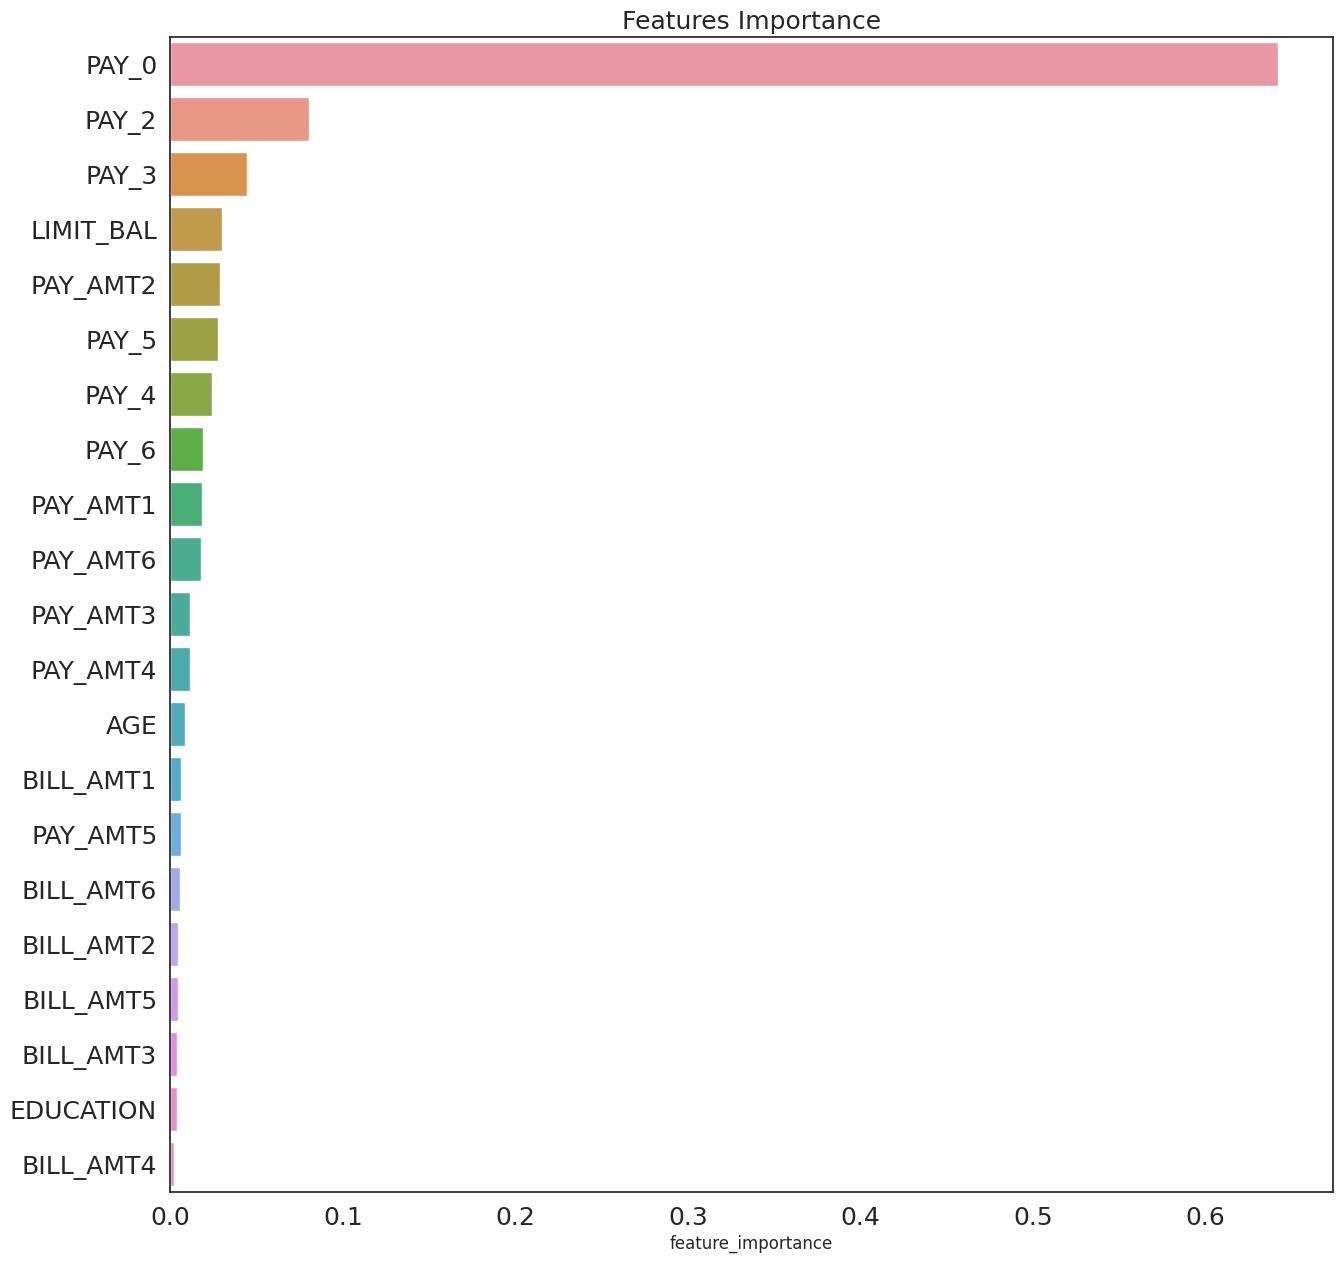

In [77]:
fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,df_test=test_woe, features_name=features_use)

In [78]:
fet_importance_GBDT_reason

,feature_name,feature_importance
19,PAY_0,0.641879
14,PAY_2,0.080198
13,PAY_3,0.044386
17,LIMIT_BAL,0.030078
11,PAY_AMT2,0.028890
15,PAY_5,0.027666
12,PAY_4,0.023903
18,PAY_6,0.019000
6,PAY_AMT1,0.018523
9,PAY_AMT6,0.017613


In [79]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(10, 5))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
    plt.show()

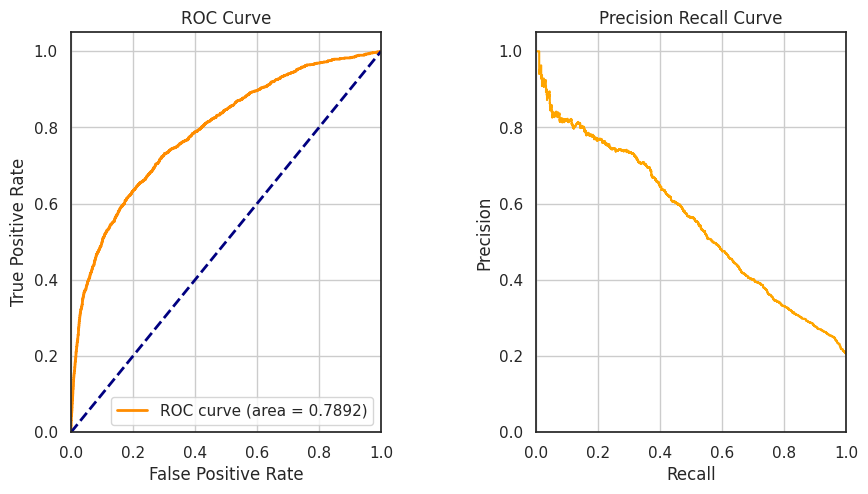

In [80]:
probs = model.predict_proba(x_test)[:,1]
# sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 7. Model Production

In [81]:
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['label']
x_test =test_woe[features_use] 
y_test = test_woe['label']

In [82]:
#Train LR
#lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

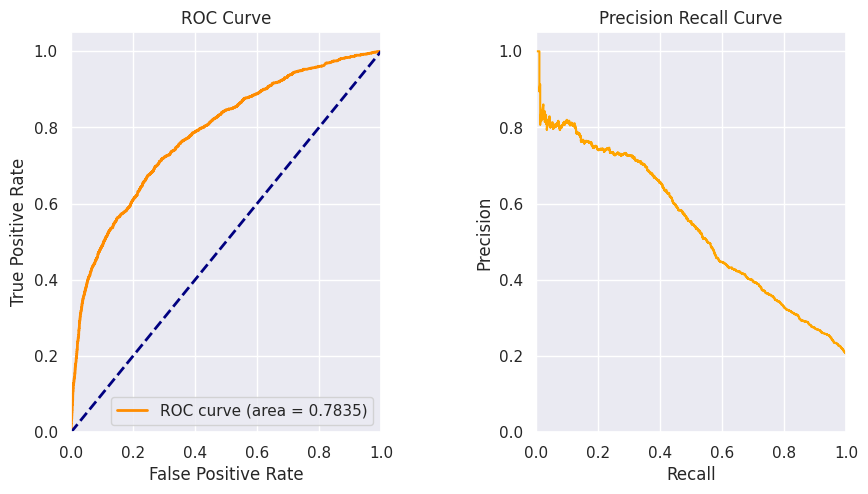

In [83]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 8. Scorecard Generation

In [84]:
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x7f5a11d26320>, pdo=80,
          transer=<toad.transform.WOETransformer object at 0x7f5a68edbe80>)

In [85]:
# save 5: save the model to disk
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [86]:
#inference on test data
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

In [87]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    30000.000000
mean       617.559238
std        118.265235
min        168.851703
25%        578.204047
50%        654.175758
75%        696.461008
max        818.460370
Name: CreditScore, dtype: float64

In [88]:
#output the scorecard
final_card_score=card.export()
len(final_card_score)

21

In [89]:
final_card_score

{'EDUCATION': {'[-inf ~ 2)': 29.66, '[2 ~ inf)': 27.2},
 'BILL_AMT4': {'[-inf ~ 2501.0)': 28.21, '[2501.0 ~ inf)': 27.97},
 'BILL_AMT6': {'[-inf ~ 19195.0)': 27.33,
  '[19195.0 ~ 50442.0)': 31.37,
  '[50442.0 ~ inf)': 26.23},
 'BILL_AMT5': {'[-inf ~ 2395.0)': 28.16,
  '[2395.0 ~ 8110.0)': 32.85,
  '[8110.0 ~ 35288.0)': 25.2,
  '[35288.0 ~ inf)': 29.41},
 'BILL_AMT1': {'[-inf ~ 2501.0)': 25.09, '[2501.0 ~ inf)': 28.87},
 'PAY_AMT5': {'[-inf ~ 1.0)': 23.01,
  '[1.0 ~ 1880.0)': 26.88,
  '[1880.0 ~ 10000.0)': 30.6,
  '[10000.0 ~ inf)': 37.59},
 'PAY_AMT1': {'[-inf ~ 6.0)': 11.44,
  '[6.0 ~ 4902.0)': 28.26,
  '[4902.0 ~ inf)': 42.7},
 'PAY_AMT4': {'[-inf ~ 1.0)': 22.23,
  '[1.0 ~ 1506.0)': 27.31,
  '[1506.0 ~ 3946.0)': 29.4,
  '[3946.0 ~ inf)': 33.87},
 'BILL_AMT2': {'[-inf ~ 2400.0)': 27.65,
  '[2400.0 ~ 8287.0)': 24.8,
  '[8287.0 ~ 35213.0)': 35.81,
  '[35213.0 ~ inf)': 23.66},
 'PAY_AMT6': {'[-inf ~ 28.0)': 20.84,
  '[28.0 ~ 480.0)': 27.67,
  '[480.0 ~ 926.0)': 22.64,
  '[926.0 ~ 1078.0)

In [90]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=score_card_df.append(temp)
score_card_df.head(30)

/tmp/ipykernel_92528/2931553124.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
/tmp/ipykernel_92528/2931553124.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
/tmp/ipykernel_92528/2931553124.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
/tmp/ipykernel_92528/2931553124.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_card_df=score_card_df.append(temp)
/tmp/ipykernel_92528/2931553124.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,variable,binning,score
0,EDUCATION,[-inf ~ 2),29.66
1,EDUCATION,[2 ~ inf),27.20
0,BILL_AMT4,[-inf ~ 2501.0),28.21
1,BILL_AMT4,[2501.0 ~ inf),27.97
0,BILL_AMT6,[-inf ~ 19195.0),27.33
1,BILL_AMT6,[19195.0 ~ 50442.0),31.37
2,BILL_AMT6,[50442.0 ~ inf),26.23
0,BILL_AMT5,[-inf ~ 2395.0),28.16
1,BILL_AMT5,[2395.0 ~ 8110.0),32.85
2,BILL_AMT5,[8110.0 ~ 35288.0),25.20


In [91]:
#save 6: save the scorcard
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

# 9. Distribution Analysis

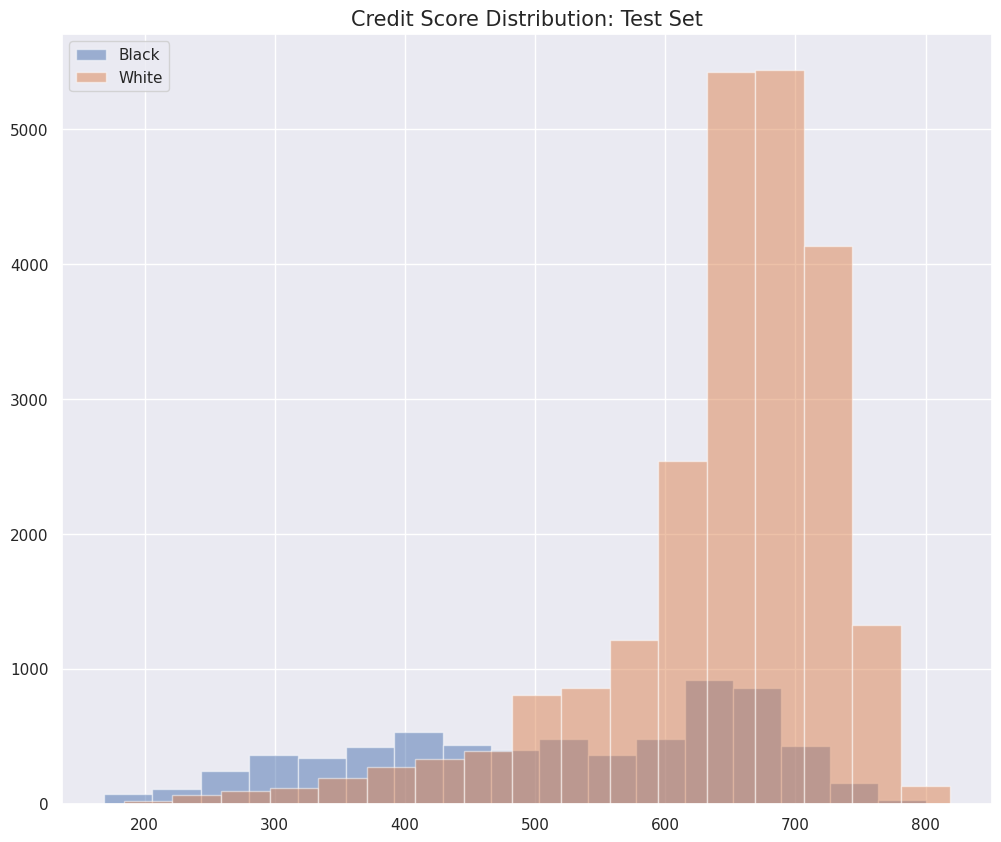

In [92]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((data['CreditScore'].max() - data['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(data[data.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(data[data.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

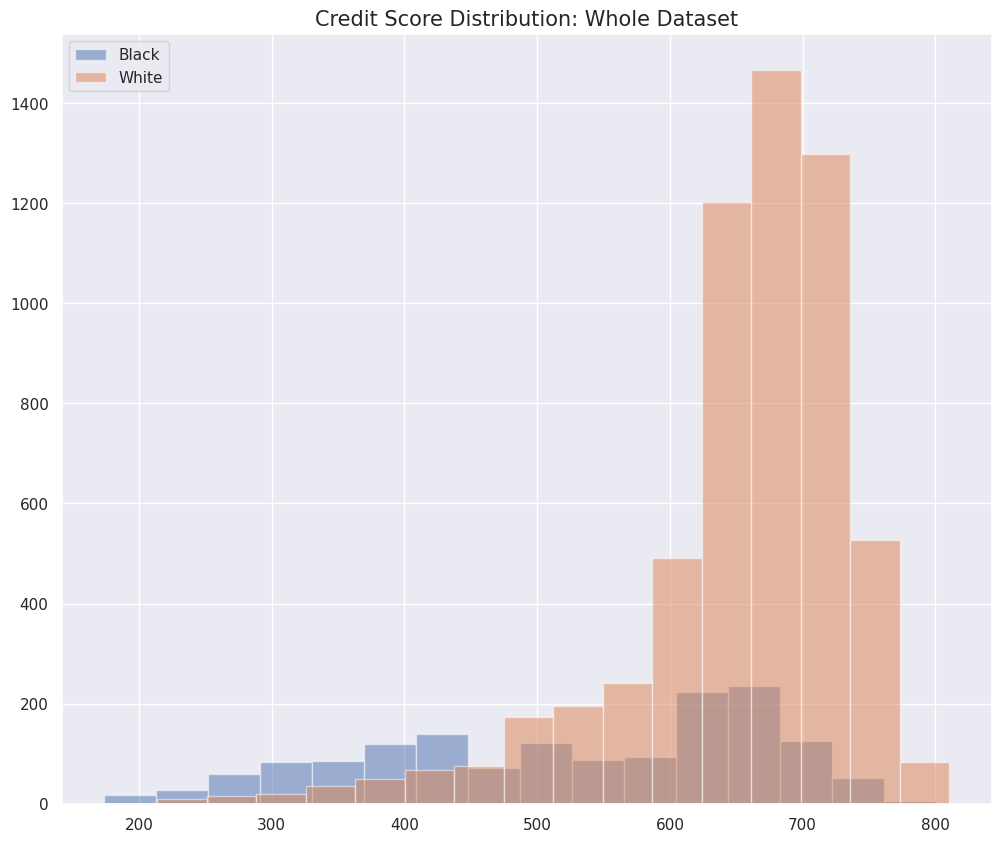

In [93]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='Black',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='White',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

# 10. Threshold Tuning

In [94]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,    
    level_2 = 250,    
    level_3 = 300,    
    level_4 = 350,    
    level_5 = 400,    
    level_6 = 450,
    level_7 = 500,
    level_8 = 800):
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)
        
    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    df_label_level= test[test.label==1].groupby(target_col)['label'].count()/ test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

In [95]:
test.CreditScore.describe()

count    7501.000000
mean      627.437143
std       113.055983
min       173.540655
25%       596.974091
50%       659.897345
75%       702.107780
max       810.644058
Name: CreditScore, dtype: float64

### Threshold Tuning & Trade-off between loss & Coverage

In [96]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -1000,
    level_0 = 250,
    level_1 = 300,    
    level_2 = 400,    
    level_3 = 500,    
    level_4 = 580,    
    level_5 = 630,    
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
                )

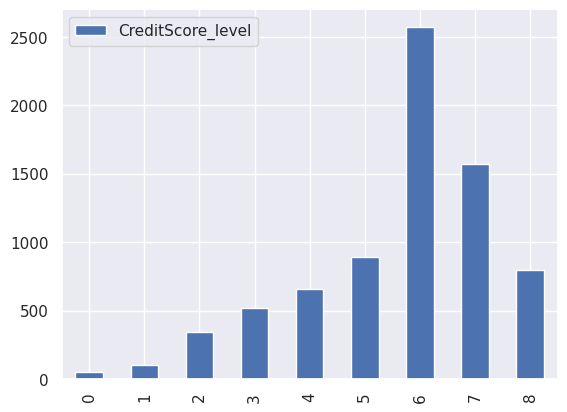

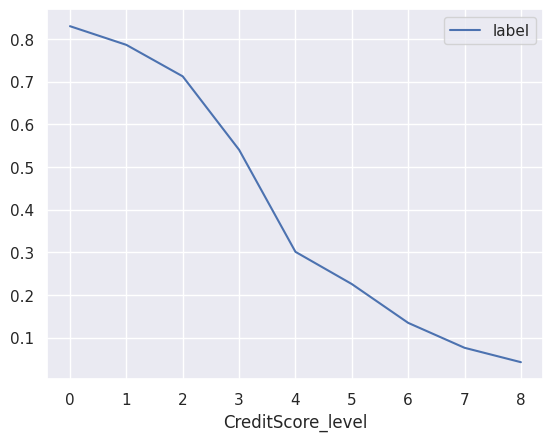

In [97]:
plot_bts_level_loss(test,target_col='CreditScore_level')

In [98]:
test[test.label==1].CreditScore_level==7

3       False
4       False
5       False
6       False
7       False
        ...  
7492    False
7495    False
7498    False
7499    False
7500    False
Name: CreditScore_level, Length: 1548, dtype: bool

In [99]:
np.sum(test[test.label==1].CreditScore_level==7)

120

In [100]:
def get_loss_coverage(test,target_level):
    
    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].label.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)
    
    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].label.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)
    
    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)
    
     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)
    
    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].label.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)
    
    
    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].label.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)
    
    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].label.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)
    
    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].label.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)
    
    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].label.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [101]:
get_loss_coverage(test,target_level='CreditScore_level')

Level 8: Loss is  0.04271356783919598 ; Coverage is  0.12800268772047707
Level 7-Level 8: Loss is  0.0650887573964497 ; Coverage is  0.3715773559549807
Level 6-Level 8: Loss is  0.10143753796315043 ; Coverage is  0.745506467327398
Level 5-Level 8: Loss is  0.1204323211528564 ; Coverage is  0.8612464303712414
Level 4-Level 8: Loss is  0.13876040703052728 ; Coverage is  0.938350411557198
Level 3-Level 8: Loss is  0.1684751570531125 ; Coverage is  0.97833025365362
Level 2-Level 8: Loss is  0.19373723621511232 ; Coverage is  0.9947925415756761
Level 1-Level 8: Loss is  0.20193340494092374 ; Coverage is  0.9984881572316479
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [102]:
#save 7: save the scorcard
data.to_csv('OrderScore_save7_whole_data.csv',index=False)

In [103]:
test.loc[0,:]

ID                    22500.000000
LIMIT_BAL            420000.000000
SEX                       2.000000
EDUCATION                 2.000000
MARRIAGE                  1.000000
AGE                      37.000000
PAY_0                     0.000000
PAY_2                     0.000000
PAY_3                     0.000000
PAY_4                    -1.000000
PAY_5                     0.000000
PAY_6                     0.000000
BILL_AMT1             36032.000000
BILL_AMT2             41932.000000
BILL_AMT3              9778.000000
BILL_AMT4            158901.000000
BILL_AMT5            161876.000000
BILL_AMT6            165378.000000
PAY_AMT1               7022.000000
PAY_AMT2               1846.000000
PAY_AMT3             163862.000000
PAY_AMT4               6000.000000
PAY_AMT5               6000.000000
PAY_AMT6               6000.000000
label                     0.000000
CreditScore             751.330191
CreditScore_level         8.000000
Name: 0, dtype: float64

In [104]:
card.predict(test)[0]

751.3301912691603

In [105]:
test.loc[10,:]

ID                   22510.000000
LIMIT_BAL            80000.000000
SEX                      2.000000
EDUCATION                3.000000
MARRIAGE                 1.000000
AGE                     45.000000
PAY_0                   -2.000000
PAY_2                   -2.000000
PAY_3                   -2.000000
PAY_4                   -2.000000
PAY_5                   -2.000000
PAY_6                   -2.000000
BILL_AMT1              640.000000
BILL_AMT2            23699.000000
BILL_AMT3             2676.000000
BILL_AMT4               -4.000000
BILL_AMT5               -4.000000
BILL_AMT6               -4.000000
PAY_AMT1             23699.000000
PAY_AMT2             22670.000000
PAY_AMT3                 0.000000
PAY_AMT4                 0.000000
PAY_AMT5                 0.000000
PAY_AMT6                 0.000000
label                    0.000000
CreditScore            664.640768
CreditScore_level        6.000000
Name: 10, dtype: float64

In [106]:
card.predict(test)[10]

664.6407680859425